# Recognition of physical activities using smartphone sensors
__Capstone project for Springboard Data Science Intensive Project__ <br>
by Mehmet Solmaz<br>
mentored by Raghunandan Patthar<br>
July 2017

## Introduction
Human activity recognition is an active research area that aims to improve the quality of human life. The signals gathered from wearable sensors provide information about a person's activities and tracking such activities is connected to lifecare and healthcare applications.

This project investigates the Human Activities and Postural Transitions (HAPT) dataset and create models that predict 
6 major and 6 transitional activities: __'WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'__, 'STAND_TO_SIT', 'SIT_TO_STAND', 'SIT_TO_LIE', 'LIE_TO_SIT', 'STAND_TO_LIE', 'LIE_TO_STAND'. Creating such models can help with more accurate real-time activity tracking. Real time activity tracking helps with the following applications: <br>

* Continuous monitoring of patients (Healthcare Management).
* Smart environments (Retail).
* Public surveillance (Security). 

### The data
In this notebook, the Human Activity Recognition dataset from UCI ML Repository was used: 

https://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions

The time-series RAW data was post-processed and multivariate input data was provided. The original dataset is in TXT format and is already split into 70-30% Train-Test split. Feature names, Target Activities and Subject ID (The volunteer who performs the activities) are provided in separate TXT files. <br>

The Features are statistical data from smartphone accelerometer and gyroscope sensors. A total of 17 signals, both time and frequency components were extracted from these sensors and statistical measures (mean, std, skewness etc.) were applied to obtained a total of 561 features. 

### Methodology

This is a supervised learning problem where the labels are given. It is also a classification problem where there are 12 classes. Several libraries (Pandas, numpy, scikit-learn, matplotlib, seaborn) were used for data wrangling, descriptive statistics, matrix operations, model creation and evaluation, dimensionality reduction, data visualization. 

<img src="Presentation1.png",width=500,height=375><br>
The flow chart of the methodology is given above. After combining the dataset and extracting distributions of target activities, I chose to implement 2 different methods where Feature Selection is followed by Classification. At the end, we compare the performance of each methods during Model Evaluation using a single-metric:f1-score. 

#### Data Wrangling

Since the data came in only 1 format (TXT), but in many different files, the files were individually treated and loaded into Dataframes. The train-test split was disregarded and feature-target datasets were combined. The size of the feature dataset is (10929, 561). There were no missing data and no dummy variables were created. 

Part of the data wrangling was done by looking at the distribution of data by Subject_ID. Every volunteer is different so are the activities recorded for each individual. This distribution also showed the data imbalance between Major and  Postural Transition activities. The initial HAR dataset only included 6 main activities. The updated dataset have both activities and postural transitions. The transitions, unfortunately, are limited in terms of recorded data. 

#### Feature Selection (and Dimensionality Reduction)

The dataset is very large with many features (561). Feature and dimensionality reduction took place using two different approaches: Principal Component Analysis and Model-based selection. The omitted features were presented visually and most important features were extracted. 


#### Classification

I have used two different classifiers and compared their performance. K Nearest Neighbor and Random Forest classifiers were selected as Machine Learning models. 

##### KNN

K-nearest neighbors is a simple algorithm that does classification based on distance function. It does not make any assumptions on the data. The number k defines how many neighbors affect the classification. If k=1, the algorithm turns into nearest neighbor algorithm. KNN is especially useful with large feature set, as in the case of computer vision and face recognition.


##### Random Forest (RF)

RF is a tree-based algorithm with multiple trees grown. Each tree votes for the class and the forest chooese the classification with most votes. There is no pruning in RF, instead tree depth parameter can be adjusted.
RF is an algorithm requiring intensive calculations, especially with increasing number of cross-validations. Here the CV was kept as 5. 

##### Cross Validation (CV)

CV is an approach to prevent over-fitting. The best choice of paramters for both KNN and RF were tested with k-fold CV. 

### Results and Model Evaluation:
* __There is no perfect recall and precision. There are confusions about all of the classes in both classifiers. The perfect 1.00 score is due to rounding.__<br>
* The average precision and recall for Major Activities (Laying, Sitting, Standing, Walking, Walking_Downstairs, and Walking_Upstairs) are over 0.95 for both classifiers. There are not many false positives for these classes except for Standing  and for Sitting classes, which are confused with each other.
* __The Transitional Activities show worse f1-scores than the Major Activities (Tables 1,2).__
* The Transitional Activities for KNN classifier show worse average f1-score for Reduced Dataset compared to original dataset.
* __As for RF classifier, the classification scores of Major and Transitional Activities marginally increased compared to KNN and the confusion rate between Standing  and for Sitting classes decreased.__
* RF Classifier is able to predict better in a data imbalance situation, i.e. between Major and Transitional Activities. A tuned RF performs better than KNN for HAPT classification problem.
* __KNN performed worse with Reduced dataset when the Whitening option of PCA was used.__


### Client Recommendations

Classification of Main Human Activities can be done with almost perfect accuracy. This results in correctly tracking major activities using a smartphone. For healthcare management, predicting major activities could be enough for following patient's mobility and calorie tracking. Along with other information such as age, height and weight, it would be easy to track an individual's life style.   

As for smart environments and public surveillance, people tend to switch between activities or not repetitively perform major activities. Since the HAPT dataset was obtained in ideal conditions where volunteers were asked to follow a specific pattern of movements, the data for target classes were very well documented and close to perfection. Although the postural transition data was much smaller compared to major activities, the classifiers were able to detect them with >70% accuracy. Companies in smart environments and public surveillance should focus on collecting more data on postural transitions to increase the detection ability. 

Companies in public surveillance should invest in tracking an individual's trajectory using Human Activity Dataset. It is  possible to build a trajectory for an individual if more classes are added as targets. For instance, the data to be collected when turning right and left, and changing lanes could help with drawing a trajectory. 

The company should look at the most important features that help classify an activity. Using less number of features will help energy effective real-time tracking due to less intensive CPU use. 


## Python Code:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from sklearn import decomposition, datasets
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
import timeit
from sklearn.metrics import f1_score

/Users/mehmetsolmaz/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/mehmetsolmaz/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


I have started from original data in TXT format at UCI ML repository. Here data is already split into train and test sets. 

In [3]:
X_test = pd.read_csv('./UCI HAR Dataset/data/X_test.txt',delim_whitespace=True, header=None)
X_test.shape

(3162, 561)

In [4]:
y_test = pd.read_csv('./UCI HAR Dataset/data/y_test.txt',delim_whitespace=True, header=None)
y_test.shape

(3162, 1)

In [5]:
X_test.head(3)

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.030914,-0.008927,0.040382,-0.938504,-0.944626,-0.759334,-0.952398,-0.950281,-0.802483,-0.757099,...,0.122830,-0.345684,-0.709087,0.006462,0.162920,-0.825886,0.271151,-0.720559,0.276779,-0.051074
1,0.042548,0.001079,-0.026236,-0.975516,-0.977502,-0.960146,-0.986694,-0.978983,-0.966820,-0.757099,...,-0.314688,-0.142804,-0.600867,-0.083495,0.017500,-0.434375,0.920593,-0.698684,0.281322,-0.076825
2,0.038297,-0.011660,-0.025643,-0.993922,-0.979215,-0.973030,-0.994298,-0.980535,-0.977508,-0.799005,...,0.114730,-0.209525,-0.645500,-0.034956,0.202302,0.064103,0.145068,-0.703355,0.280062,-0.072302


In [6]:
y_test.head(3)

,0
0,5
1,5
2,5


In [7]:
feature_names_extracted=pd.read_csv('./UCI HAR Dataset/features.txt',delim_whitespace=True, header=None)
feature_names_extracted.head(4)
feature_names_extracted.shape

(561, 2)

In [8]:
feature_names=feature_names_extracted.iloc[:,1]
feature_names.shape
feature_names[2]

'tBodyAcc-mean()-Z'

In [9]:
X_test = X_test.rename(columns = feature_names)
X_test.head(6)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.030914,-0.008927,0.040382,-0.938504,-0.944626,-0.759334,-0.952398,-0.950281,-0.802483,-0.757099,...,0.122830,-0.345684,-0.709087,0.006462,0.162920,-0.825886,0.271151,-0.720559,0.276779,-0.051074
1,0.042548,0.001079,-0.026236,-0.975516,-0.977502,-0.960146,-0.986694,-0.978983,-0.966820,-0.757099,...,-0.314688,-0.142804,-0.600867,-0.083495,0.017500,-0.434375,0.920593,-0.698684,0.281322,-0.076825
2,0.038297,-0.011660,-0.025643,-0.993922,-0.979215,-0.973030,-0.994298,-0.980535,-0.977508,-0.799005,...,0.114730,-0.209525,-0.645500,-0.034956,0.202302,0.064103,0.145068,-0.703355,0.280062,-0.072302
3,0.036205,-0.018148,-0.025240,-0.994845,-0.981534,-0.976175,-0.995169,-0.983020,-0.980785,-0.798401,...,0.164515,-0.359352,-0.738474,-0.017067,0.154438,0.340134,0.296407,-0.699545,0.284093,-0.070079
4,0.038034,-0.013437,-0.032899,-0.993955,-0.977493,-0.984290,-0.994006,-0.977354,-0.985899,-0.798401,...,-0.056085,-0.544467,-0.846150,-0.002223,-0.040046,0.736715,-0.118545,-0.692849,0.290701,-0.066849
5,0.039803,-0.004316,-0.022932,-0.994558,-0.979556,-0.974890,-0.994480,-0.979701,-0.978969,-0.797702,...,0.133895,-0.504415,-0.856842,-0.095681,0.048849,0.760684,-0.072216,-0.690425,0.294875,-0.061498


In [10]:
activity_names_extracted=pd.read_csv('./UCI HAR Dataset/data/activity_labels.txt',delim_whitespace=True, header=None)
activity_names_extracted

,0,1
0,1,WALKING
1,2,WALKING_UPSTAIRS
2,3,WALKING_DOWNSTAIRS
3,4,SITTING
4,5,STANDING
5,6,LAYING
6,7,STAND_TO_SIT
7,8,SIT_TO_STAND
8,9,SIT_TO_LIE
9,10,LIE_TO_SIT


In [11]:
X_test.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-meanFreq()', 'fBodyBodyGyroJerkMag-skewness()',
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)'],
      dtype='object', length=561)

In [12]:
mapping = {1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3:'WALKING_DOWNSTAIRS', 4:'SITTING', 5:'STANDING', 6:'LAYING', 7:'STAND_TO_SIT', 8:'SIT_TO_STAND',9:'SIT_TO_LIE', 10:'LIE_TO_SIT', 11:'STAND_TO_LIE',12:'LIE_TO_STAND'}

In [13]:
y_test=y_test.applymap(lambda s: mapping.get(s) if s in mapping else s)

In [14]:
y_test.head(5)

,0
0,STANDING
1,STANDING
2,STANDING
3,STANDING
4,STANDING


In [15]:
y_test.shape

(3162, 1)

In [16]:
y_test=y_test.rename(columns = {0:'target_activity'})

In [17]:
y_test.head()

,target_activity
0,STANDING
1,STANDING
2,STANDING
3,STANDING
4,STANDING


In [18]:
X_test.dtypes.head(3)

tBodyAcc-mean()-X    float64
tBodyAcc-mean()-Y    float64
tBodyAcc-mean()-Z    float64
dtype: object

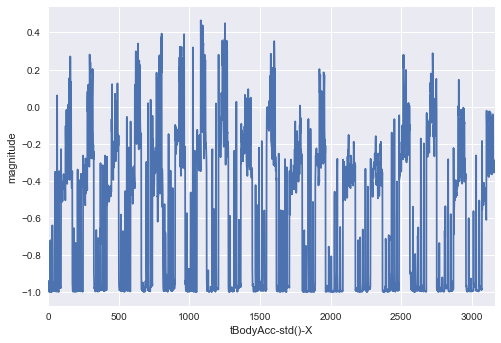

In [19]:
plt.figure();
X_test.iloc[:,3].plot() # plot the column
plt.xlabel(feature_names[3])
plt.ylabel('magnitude')
plt.show()

(7767, 561)


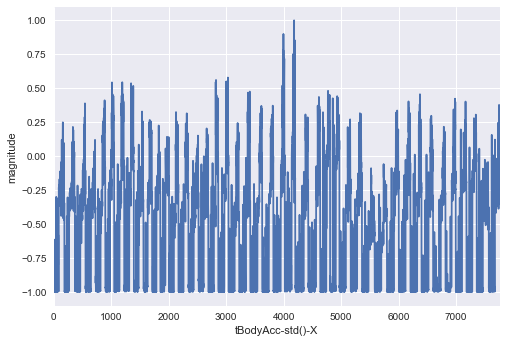

In [20]:
X_train = pd.read_csv('./UCI HAR Dataset/data/X_train.txt',delim_whitespace=True, header=None)
print(X_train.shape)
plt.figure();
X_train.iloc[:,3].plot() # plot the column
plt.xlabel(feature_names[3])
plt.ylabel('magnitude')
plt.show()

In [21]:
y_train = pd.read_csv('./UCI HAR Dataset/data/y_train.txt',delim_whitespace=True, header=None)
y_train.shape

(7767, 1)

In [22]:
X_train = X_train.rename(columns = feature_names)
X_train.head(3)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.043580,-0.005970,-0.035054,-0.995381,-0.988366,-0.937382,-0.995007,-0.988816,-0.953325,-0.794796,...,-0.012236,-0.314848,-0.713308,-0.112754,0.030400,-0.464761,-0.018446,-0.841559,0.179913,-0.051718
1,0.039480,-0.002131,-0.029067,-0.998348,-0.982945,-0.971273,-0.998702,-0.983315,-0.974000,-0.802537,...,0.202804,-0.603199,-0.860677,0.053477,-0.007435,-0.732626,0.703511,-0.845092,0.180261,-0.047436
2,0.039978,-0.005153,-0.022651,-0.995482,-0.977314,-0.984760,-0.996415,-0.975835,-0.985973,-0.798477,...,0.440079,-0.404427,-0.761847,-0.118559,0.177899,0.100699,0.808529,-0.849230,0.180610,-0.042271


In [23]:
y_train=y_train.applymap(lambda s: mapping.get(s) if s in mapping else s)

In [24]:
y_train.head(5)

,0
0,STANDING
1,STANDING
2,STANDING
3,STANDING
4,STANDING


In [25]:
y_train=y_train.rename(columns = {0:'target_activity'})

In [26]:
frames = [X_test, X_train]

In [27]:
X = pd.concat(frames)

In [28]:
X.shape

(10929, 561)

In [29]:
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)

(3162, 561)
(7767, 561)
(3162, 1)
(7767, 1)


In [30]:
frames2 = [y_test, y_train]

In [31]:
y = pd.concat(frames2)

In [32]:
y.shape

(10929, 1)

In [33]:
subject_id_test=pd.read_csv('./UCI HAR Dataset/data/subject_id_test.txt',delim_whitespace=True, header=None)
subject_id_train=pd.read_csv('./UCI HAR Dataset/data/subject_id_train.txt',delim_whitespace=True, header=None)

In [34]:
frames3 = [subject_id_test, subject_id_train]

In [35]:
subject = pd.concat(frames3)
subject=subject.rename(columns = {0:'subject_id'})
print(subject.shape)
subject.head(5)

(10929, 1)


,subject_id
0,2
1,2
2,2
3,2
4,2


__The model has 12 classes and the feature dataset was collected from 30 individuals. Looking at the data distribution among Volunteers who performed the activities would give us a great overview.__ <br>

Pivoting columns is a great way to group the results by two sets of values.

In [36]:
target_subject_table=pd.crosstab(y['target_activity'],subject['subject_id'])
target_subject_table

subject_id,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
target_activity,,,,,,,,,,,,,,,,,,,,,
LAYING,48,49,63,52,51,56,50,55,54,59,...,90,72,72,73,75,76,76,79,69,73
LIE_TO_SIT,3,4,4,4,5,2,1,3,2,1,...,4,3,2,3,5,2,2,0,3,3
LIE_TO_STAND,3,2,2,2,2,3,3,1,2,1,...,4,3,2,6,5,3,1,2,2,2
SITTING,47,46,52,49,43,56,47,45,53,55,...,85,62,68,71,66,79,72,74,60,64
SIT_TO_LIE,4,3,2,4,5,2,4,2,3,2,...,4,2,4,4,3,3,4,4,6,4
SIT_TO_STAND,2,2,1,2,1,1,0,0,0,0,...,1,0,1,0,2,1,0,1,2,2
STANDING,55,55,63,56,57,58,54,57,49,46,...,94,65,71,71,75,77,82,80,67,64
STAND_TO_LIE,6,7,4,7,7,6,4,4,4,3,...,6,2,5,8,3,2,3,0,3,3
STAND_TO_SIT,3,2,2,3,3,2,0,1,1,1,...,2,2,3,2,3,2,2,4,2,2


The data is almost evenly distributed among Major aActivities [1-6] for all subjects, the observations for Postural Transition activities are much less. 

A better way to look at this data is through a Bar Plot, where we look at activities and how many datapoints each subject recorded during that activity. 

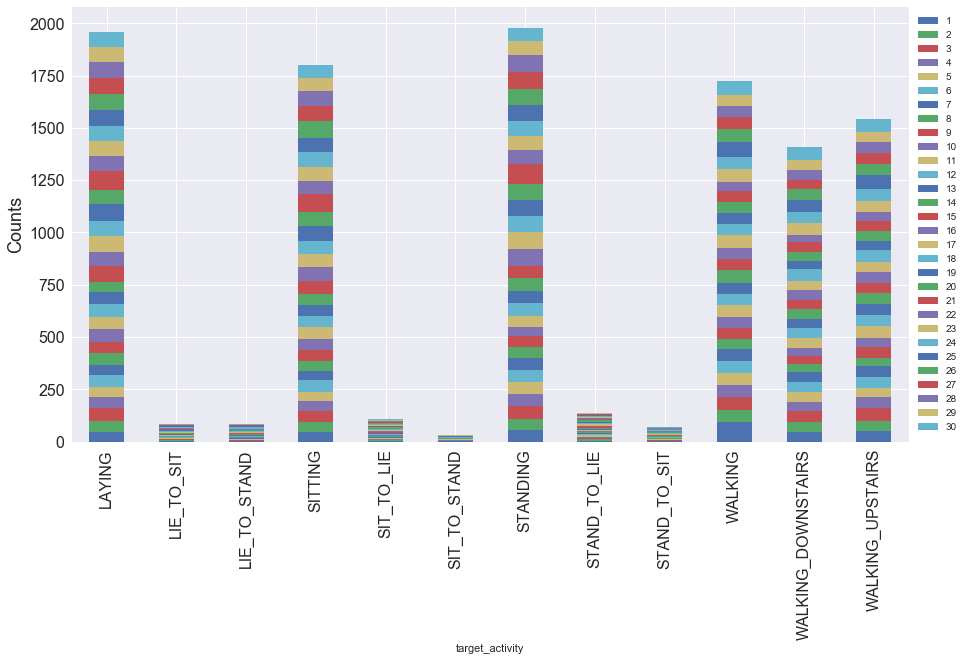

In [37]:
target_subject_table.plot(kind='bar',figsize=(15,8), stacked=True, fontsize=16).legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.boxplot(target_subject_table, 0, 'gD')
#plt.show()
plt.ylabel('Counts', fontsize=18)
plt.show()

We can also use boxplot to look at statistics about the 12 activities. This gives us mean, median and specific percentiles.

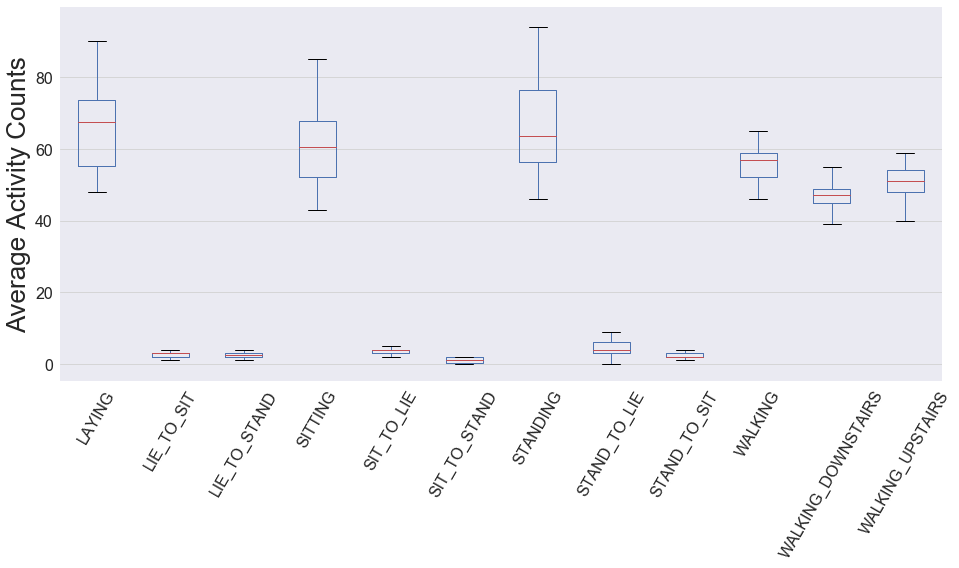

In [38]:
fig = plt.figure()
sns.set_style("dark")
bp = target_subject_table.transpose().plot(kind='box', notch=0, sym='+', vert=1, whis=1.8, figsize=(14, 8), fontsize=16)
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
bp.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.9)
bp.set_ylabel('Average Activity Counts', fontsize=26)
bp.set_axisbelow(True)
plt.xticks(rotation=60)
plt.show()
fig.savefig('plot.png')

Certain activities have a wider spread than the others. Transitional activities have small number of counts.<br>
__There is an imbalance in the feature dataset that would affect the classification accuracies of Postural Transition Classes.__

### Principal Component Analysis for dimensionality reduction and KNN classifier
PCA is an unsupervised learning method to transform the data to a more informative scale for further processing. <br>
One of the most common applications of PCA is visualizing high-dimensional datasets, which is exactly our case. We have 561 features.

Normally, we would scale the data so that each feature has a unit variance. The HAPT data already comes with features normalized and bounded within [-1,1]. So we will skip this step.

I first want to explore PCA on this dataset. I will try visualizing 1st and 2nd principal components, and move on to Scree plot to see how much of the data I can keep.

In [39]:
# By default, PCA only rotates (and shifts) the data, but keeps all principal components. 
# To reduce the dimensionality of the data, we need to specify how many components we want to keep 
# when creating the PCA object: lets keep only 2
start_time = timeit.default_timer()
pca = PCA(n_components=2, whiten=True)
# fit PCA model to the whole HAR data 
pca.fit(X)
  # transform data onto the first two principal components
X_pca = pca.transform(X)
print("Original shape: {}".format(str(X.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))
print(type(X_pca))

elapsed = timeit.default_timer() - start_time
print(elapsed)

Original shape: (10929, 561)
Reduced shape: (10929, 2)
<class 'numpy.ndarray'>
0.5356634329946246


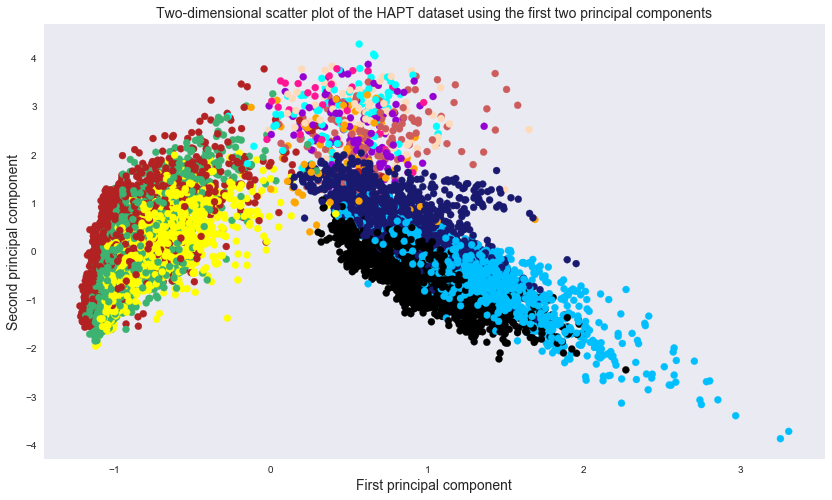

In [40]:
# plot first vs. second principal component, colored by class

labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING',
          'STANDING', 'LAYING', 'STAND_TO_SIT', 'SIT_TO_STAND', 
          'SIT_TO_LIE', 'LIE_TO_SIT', 'STAND_TO_LIE', 'LIE_TO_STAND']

colors = {'WALKING':'#000000', 'WALKING_UPSTAIRS':'#191970', 'WALKING_DOWNSTAIRS':'#00bfff', 'SITTING':'#3cb371', 
         'STANDING':'#ffff00', 'LAYING':'#b22222', 'STAND_TO_SIT':'#ffa500', 'SIT_TO_STAND':'#ff1493',
         'SIT_TO_LIE':'#9400d3', 'LIE_TO_SIT':'#00ffff', 'STAND_TO_LIE':'#cd5c5c', 'LIE_TO_STAND':'#ffdab9'}

fig=plt.figure(figsize=(14, 8))

ax1=fig.add_subplot(111)
ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y['target_activity'].apply(lambda x: colors[x]), label = labels)
# plt.gca().set_aspect("equal")
plt.xlabel("First principal component", fontsize=14)
plt.ylabel("Second principal component", fontsize=14)
plt.title("Two-dimensional scatter plot of the HAPT dataset using the first two principal components", fontsize=14)

plt.show()

In [41]:
print("PCA component shape: {}".format(pca.components_.shape))
print("PCA components:\n{}".format(pca.components_))

PCA component shape: (2, 561)
PCA components:
[[ -2.58173495e-05   7.82486660e-05   1.26437068e-04 ...,  -3.73422655e-02
    2.68934328e-02   2.12956997e-02]
 [  2.57045067e-03   1.99911574e-03   1.03231742e-03 ...,   3.51510049e-02
   -1.34691711e-02  -1.91451479e-02]]


#### It would be hard to visualize 561 feature names and the PCA components. So, lets move on to Feature Extraction. 
How many principal components to choose for our new feature subspace? A good measure is the "explained variance," that tells us how much information (variance) can be attributed to each of the principal components.

In [42]:
print("PCA explained variance ratio:\n{}".format(pca.explained_variance_ratio_))
print("PCA cumulative variance explained by first i+1 dimension:\n{}".format(pca.explained_variance_ratio_.cumsum()))

PCA explained variance ratio:
[ 0.58108072  0.06262223]
PCA cumulative variance explained by first i+1 dimension:
[ 0.58108072  0.64370294]


Looks like most of the variance (64.37%) can be explained by the first two principal components alone. 

If we want more than 64% variance, we need to add more components. We can do a Scree Plot and look at the elbow point.

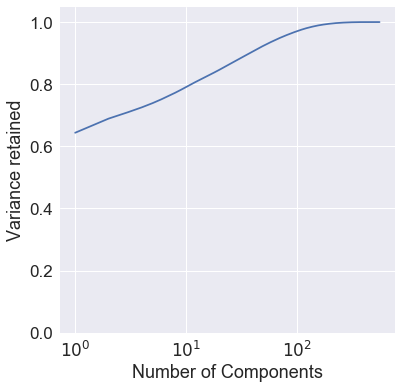

In [43]:
# Lets look at how much data are we throwing away? 
# Lets try and plot number of components versus explained variance ratio 
# as a cumulative sum to find out how much data are we throwing away?
# this is called a Scree Plot
sns.set()
plt.figure(figsize=(6, 6))
sns.set(font_scale=1.7)
pca_new = PCA(561).fit(X)
plt.semilogx(np.cumsum(pca_new.explained_variance_ratio_))
plt.xlabel('Number of Components', fontsize = 18)
plt.ylabel('Variance retained', fontsize = 18)
plt.ylim(0,1.05)
plt.show()

This is a nice plot showing that we need at least 120 components (elbow point) to retain a good ratio of variance.

In [44]:
#Fitting PCA to the HAR dataset and transforming it into 2 principal components
pca=PCA(0.98, whiten=True)
X_proj = pca.fit_transform(X)
print(X_proj.shape)

(10929, 123)


We can explain 98% of the data with 123 principal components. 

#### PCA does not discard or retain the original features. It projects them onto principal components. 

####  Now lets divide the dataset into train and test sets, then apply PCA on both.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print("X_train.shape: {}".format(X_train.shape))
print("X_test.shape: {}".format(X_test.shape))
print("y_train.shape: {}".format(y_train.shape))
print("y_test.shape: {}".format(y_test.shape))

X_train.shape: (8196, 561)
X_test.shape: (2733, 561)
y_train.shape: (8196, 1)
y_test.shape: (2733, 1)


In [46]:
pca = PCA(0.98, whiten=True).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("X_train_pca.shape: {}".format(X_train_pca.shape))
print("X_test_pca.shape: {}".format(X_test_pca.shape))

X_train_pca.shape: (8196, 123)
X_test_pca.shape: (2733, 123)


PCA on training data for 98% variance also gave 123 components. The components are sorted by _explained_variance_.
#### Now lets try our first classifier (KNN) on the reduced feature dataset without any parameter optimization.

In [47]:
# build a KNeighborsClassifier using 3 neighbors
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_pca, y_train)
# predict the class labels 
pred_knn = knn.predict(X_test_pca)
# In multi-label classification, this is the subset accuracy which is a harsh 
# metric since you require for each sample that each label set be correctly predicted.
print("Test set accuracy: {:.4f}".format(accuracy_score(y_test, pred_knn)))

/Users/mehmetsolmaz/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  app.launch_new_instance()


Test set accuracy: 0.9283


In [48]:
labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING',
          'STANDING', 'LAYING', 'STAND_TO_SIT', 'SIT_TO_STAND', 
          'SIT_TO_LIE', 'LIE_TO_SIT', 'STAND_TO_LIE', 'LIE_TO_STAND']
confusion = confusion_matrix(y_test, pred_knn, labels=labels)

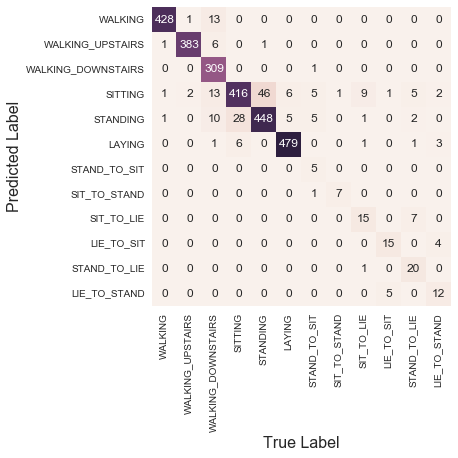

In [49]:
# a better way to visualize the Confusion Matrix for the multiclass KNN classifier
sns.set()
sns.heatmap(confusion.T, square=True,annot=True,fmt='d',cbar=False,xticklabels=labels,yticklabels=labels)
plt.xlabel('True Label', fontsize=16)
plt.ylabel('Predicted Label', fontsize=16)
plt.show()

#### Lets evaluate training and test set performance with different numbers of neighbors. See how different we are from 92.8% accuracy.

In [50]:
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)
training_accuracy = []
test_accuracy = []

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train_pca, y_train)
    # record training set accuracy 
    training_accuracy.append(clf.score(X_train_pca, y_train)) 
    # record generalization accuracy 
    test_accuracy.append(clf.score(X_test_pca, y_test))
    

/Users/mehmetsolmaz/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


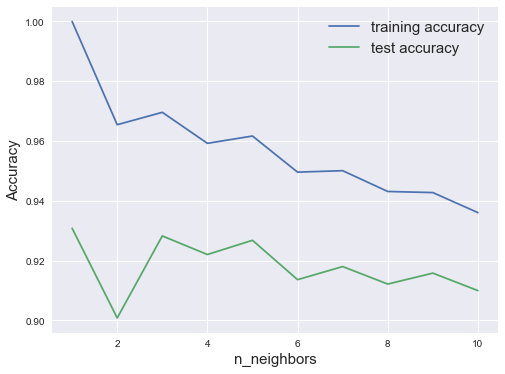

In [51]:
plt.figure(figsize=(8,6))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("n_neighbors", fontsize=15)
plt.legend(fontsize=15)
plt.show()

n_neighbors=3 seems to be the optimum parameter for KNN.

#### Up until now, we used train-test split and evaluate the Classification performance of KNN. 
#### We can now use K-fold Cross Validation on the original (X) and projected dataset (X_proj) and the target (y). Cross validation is necessary to prevent overfitting of the model. 
#### Lets use the whole feature dataset first.

In [52]:
# CV on the original dataset with 561 features.
start_time = timeit.default_timer()

kfold = KFold(n_splits=5, shuffle=True, random_state=0)
knn = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(knn, X, y.target_activity.values, cv=kfold)
predicted = cross_val_predict(knn, X, y, cv=kfold)
elapsed = timeit.default_timer() - start_time
print(elapsed)

print("Cross-validation scores:\n{}".format(scores))
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

/Users/mehmetsolmaz/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mehmetsolmaz/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mehmetsolmaz/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mehmetsolmaz/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_val

163.77055326499976
Cross-validation scores:
[ 0.95654163  0.95333943  0.95562672  0.95379689  0.95789474]
Accuracy: 0.9554 (+/- 0.0034)


__When the classes are imbalanced, accuracy is not a great evaluation metric. Multiclass classification problems require require Confusion Matrix and Classification Report.__

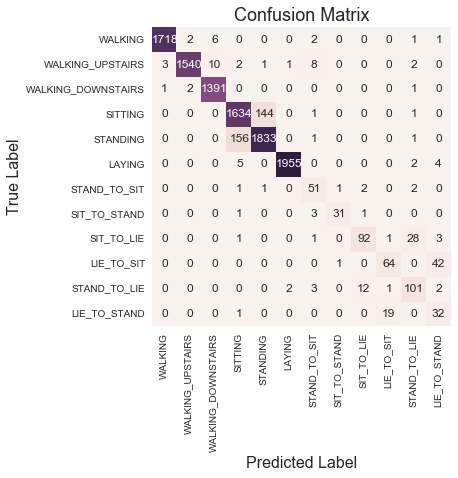

In [53]:
confusion = confusion_matrix(y, predicted, labels=labels)
sns.set()
sns.heatmap(confusion.T, square=True,annot=True,fmt='d',cbar=False,xticklabels=labels,yticklabels=labels)
plt.ylabel('True Label', fontsize=16)
plt.xlabel('Predicted Label', fontsize=16)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In the Confusion Matrix, we can clearly see the False Negatives and False Positives. 

Lets remember:
* TPs are the diagonal terms.
* Total # of FN's for a class is the sum of values in the corresponding row (excluding TPs)
* Total # of FP's for a class is the sum of values in the corresponding column (excluding TPs)
* Total # of TN's for a class is the sum of all rows and columns excluding that class's column and row. 
* Precision = TP/(TP+FP)
* Recall = TP/(TP+FN)

In [54]:
# the classification report for all activities.
print(classification_report(predicted, y))

                    precision    recall  f1-score   support

            LAYING       1.00      0.99      1.00      1966
        LIE_TO_SIT       0.75      0.60      0.67       107
      LIE_TO_STAND       0.38      0.62      0.47        52
           SITTING       0.91      0.92      0.91      1780
        SIT_TO_LIE       0.86      0.73      0.79       126
      SIT_TO_STAND       0.94      0.86      0.90        36
          STANDING       0.93      0.92      0.92      1991
      STAND_TO_LIE       0.73      0.83      0.78       121
      STAND_TO_SIT       0.73      0.88      0.80        58
           WALKING       1.00      0.99      1.00      1730
WALKING_DOWNSTAIRS       0.99      1.00      0.99      1395
  WALKING_UPSTAIRS       1.00      0.98      0.99      1567

       avg / total       0.96      0.96      0.96     10929



In [55]:
# the classification report for Postural Transition activities.
print(classification_report(predicted, y,labels=['LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'STAND_TO_LIE', 'STAND_TO_SIT']))

              precision    recall  f1-score   support

  LIE_TO_SIT       0.75      0.60      0.67       107
LIE_TO_STAND       0.38      0.62      0.47        52
  SIT_TO_LIE       0.86      0.73      0.79       126
SIT_TO_STAND       0.94      0.86      0.90        36
STAND_TO_LIE       0.73      0.83      0.78       121
STAND_TO_SIT       0.73      0.88      0.80        58

 avg / total       0.75      0.74      0.74       500



In [56]:
# Save f1-scores to later use for plotting
knn_f1_whole_data = f1_score(predicted, y, average=None)

__Now lets use the reduced dataset (X_proj) and evaluate the model one more time.__

In [57]:
start_time = timeit.default_timer()

kfold = KFold(n_splits=5, shuffle=True, random_state=0)
knn = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(knn, X_proj, y.target_activity.values, cv=kfold)
predicted = cross_val_predict(knn, X_proj, y, cv=kfold)
elapsed = timeit.default_timer() - start_time
print(elapsed)

print("Cross-validation scores:\n{}".format(scores))
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

/Users/mehmetsolmaz/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mehmetsolmaz/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mehmetsolmaz/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mehmetsolmaz/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_val

68.38493057197775
Cross-validation scores:
[ 0.92406221  0.91903019  0.92909424  0.93321134  0.91853547]
Accuracy: 0.9248 (+/- 0.0114)


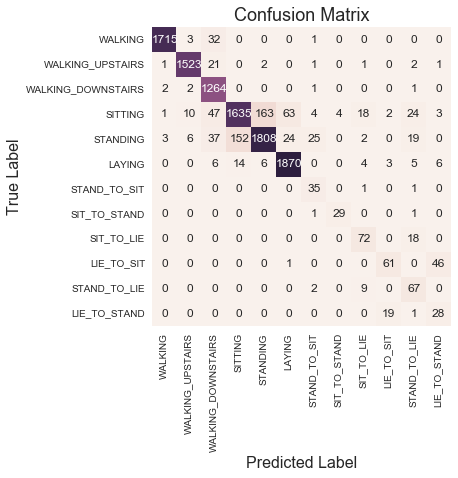

In [58]:
confusion = confusion_matrix(y, predicted, labels=labels)
sns.set()
sns.heatmap(confusion.T, square=True,annot=True,fmt='d',cbar=False,xticklabels=labels,yticklabels=labels)
plt.ylabel('True Label', fontsize=16)
plt.xlabel('Predicted Label', fontsize=16)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [59]:
# the classification report for all activities.
print(classification_report(predicted, y))

                    precision    recall  f1-score   support

            LAYING       0.96      0.98      0.97      1914
        LIE_TO_SIT       0.72      0.56      0.63       108
      LIE_TO_STAND       0.33      0.58      0.42        48
           SITTING       0.91      0.83      0.87      1974
        SIT_TO_LIE       0.67      0.80      0.73        90
      SIT_TO_STAND       0.88      0.94      0.91        31
          STANDING       0.91      0.87      0.89      2076
      STAND_TO_LIE       0.48      0.86      0.62        78
      STAND_TO_SIT       0.50      0.95      0.65        37
           WALKING       1.00      0.98      0.99      1751
WALKING_DOWNSTAIRS       0.90      1.00      0.94      1270
  WALKING_UPSTAIRS       0.99      0.98      0.98      1552

       avg / total       0.93      0.92      0.93     10929



In [60]:
# Save f1-scores to later use for plotting
knn_f1_reduced_data = f1_score(predicted, y, average=None)

In [61]:
# the classification report for Postural Transition activities.
print(classification_report(predicted, y,labels=['LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'STAND_TO_LIE', 'STAND_TO_SIT']))

              precision    recall  f1-score   support

  LIE_TO_SIT       0.72      0.56      0.63       108
LIE_TO_STAND       0.33      0.58      0.42        48
  SIT_TO_LIE       0.67      0.80      0.73        90
SIT_TO_STAND       0.88      0.94      0.91        31
STAND_TO_LIE       0.48      0.86      0.62        78
STAND_TO_SIT       0.50      0.95      0.65        37

 avg / total       0.61      0.74      0.65       392



### Model-based feature selection and RandomForest classifier

__PCA was able to reduce the dimensions from 561 to 123. However, the features are transformed and only principal components with large variance are kept.__

We can also try Model-Based feature selection and have a look at the original features we selected. Tree based classifiers provide the importance of features. 

In [62]:
## Lets first try the reduced dataset (X) and evaluate the RF model.
est = RandomForestClassifier(n_estimators=100, random_state=42)
select = SelectFromModel(est, prefit=False, threshold="0.75*mean")
select.fit(X, y)

X_reduced= select.transform(X)
print("X.shape: {}".format(X.shape))
print("X_reduced.shape: {}".format(X_reduced.shape))

/Users/mehmetsolmaz/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/from_model.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


X.shape: (10929, 561)
X_reduced.shape: (10929, 146)


Model-based feature selection is able to reduce the feature size to 146 by keeping the threshold three quarters of the mean.

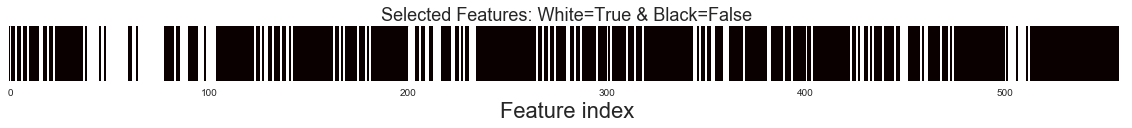

In [63]:
# Visualization of selected features out of 561.
mask = select.get_support()
fig = plt.figure(figsize=(20,1))
ax = fig.add_subplot(111)
ax.imshow(mask.reshape(1, -1), aspect='auto', cmap=plt.cm.hot, interpolation='nearest')
sns.set_style("whitegrid", {'axes.grid' : False})
ax.axes.get_yaxis().set_visible(False)
sns.set(font_scale=2) 
plt.xlabel("Feature index", fontsize=22)
plt.title("Selected Features: White=True & Black=False", fontsize=18)
plt.show()

__Grid Search on RF classifier is necessary to find optimum hyperparameters:__

In [64]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y.target_activity.values, test_size=0.25, random_state=0)

start_time = timeit.default_timer()

clf = RandomForestClassifier(random_state=42)
param_grid = {'max_depth' : [None, 10,20],
              'max_features' : ['sqrt', 'log2'],
              'n_estimators' :[1, 10, 50, 100]}
forest = GridSearchCV(clf, param_grid= param_grid, cv=5) 
forest.fit(X_train,y_train)
elapsed = timeit.default_timer() - start_time
print(elapsed)

# forest.fit(X_reduced,y.target_activity.values)
print(forest.best_params_)


224.0694608539925
{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}


In [65]:
print("Best parameters: {}".format(forest.best_params_))
print("Best cross-validation score: {:.4f}".format(forest.best_score_))

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
Best cross-validation score: 0.9577


In [66]:
forest.grid_scores_

[mean: 0.88275, std: 0.00641, params: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 1},
 mean: 0.94790, std: 0.00587, params: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 10},
 mean: 0.95583, std: 0.00467, params: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 50},
 mean: 0.95766, std: 0.00595, params: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100},
 mean: 0.87933, std: 0.01053, params: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 1},
 mean: 0.94253, std: 0.00311, params: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 10},
 mean: 0.95351, std: 0.00470, params: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 50},
 mean: 0.95632, std: 0.00507, params: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 100},
 mean: 0.88543, std: 0.00775, params: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 1},
 mean: 0.93875, std: 0.00798, params: {'max_depth': 10, 'max_features': 'sqr

In [67]:
start_time = timeit.default_timer()

clf = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='sqrt',random_state=42)
clf.fit(X_train,y_train)
predicted = clf.predict(X_test)
elapsed = timeit.default_timer() - start_time
print(elapsed)

7.561772052984452


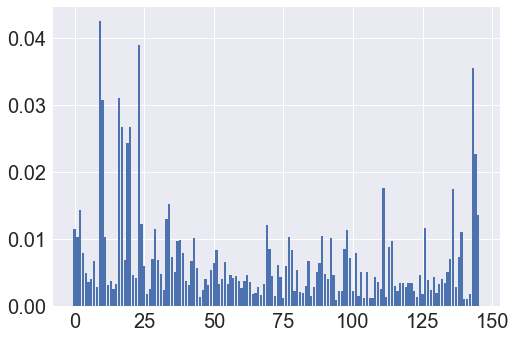

In [68]:
plt.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
sns.set(font_scale=1.8)
plt.show()

In [69]:
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_[0:20]), feature_names), reverse=True))

Features sorted by their score:
[(0.042500000000000003, 'tBodyAcc-max()-X'), (0.031099999999999999, 'tBodyAcc-energy()-X'), (0.030800000000000001, 'tBodyAcc-max()-Y'), (0.026700000000000002, 'tBodyAcc-energy()-Y'), (0.024400000000000002, 'tBodyAcc-iqr()-X'), (0.0143, 'tBodyAcc-mean()-Z'), (0.0115, 'tBodyAcc-mean()-X'), (0.0104, 'tBodyAcc-max()-Z'), (0.0103, 'tBodyAcc-mean()-Y'), (0.0077999999999999996, 'tBodyAcc-std()-X'), (0.0067999999999999996, 'tBodyAcc-energy()-Z'), (0.0067000000000000002, 'tBodyAcc-mad()-Y'), (0.0050000000000000001, 'tBodyAcc-std()-Y'), (0.0041000000000000003, 'tBodyAcc-mad()-X'), (0.0037000000000000002, 'tBodyAcc-min()-Y'), (0.0035999999999999999, 'tBodyAcc-std()-Z'), (0.0033, 'tBodyAcc-sma()'), (0.0030999999999999999, 'tBodyAcc-min()-X'), (0.0028, 'tBodyAcc-mad()-Z'), (0.0025000000000000001, 'tBodyAcc-min()-Z')]


__According to the model, the strongest feature leading to model evaluation is tBodyAcc-max()-X, Maximum body acceleration in X direction.__ 

In [70]:
print(classification_report(predicted, y_test))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       504
        LIE_TO_SIT       0.78      0.82      0.80        17
      LIE_TO_STAND       0.84      0.80      0.82        20
           SITTING       0.96      0.97      0.96       471
        SIT_TO_LIE       0.80      0.74      0.77        27
      SIT_TO_STAND       0.67      0.89      0.76         9
          STANDING       0.97      0.96      0.97       506
      STAND_TO_LIE       0.71      0.77      0.74        31
      STAND_TO_SIT       0.76      0.76      0.76        17
           WALKING       0.98      0.99      0.99       424
WALKING_DOWNSTAIRS       0.99      0.98      0.98       346
  WALKING_UPSTAIRS       0.99      0.98      0.99       361

       avg / total       0.97      0.97      0.97      2733



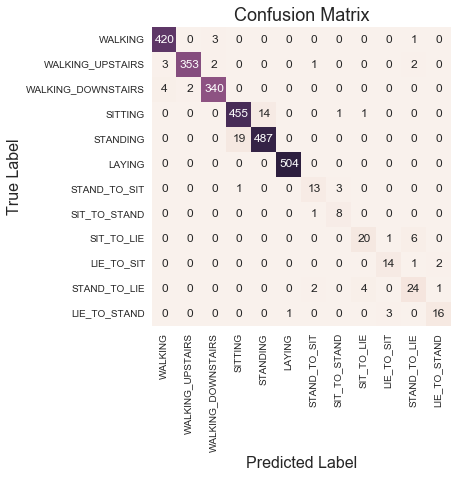

In [71]:
confusion = confusion_matrix(y_test, predicted, labels=labels)
sns.set()
sns.heatmap(confusion.T, square=True,annot=True,fmt='d',cbar=False,xticklabels=labels,yticklabels=labels)
plt.ylabel('True Label', fontsize=16)
plt.xlabel('Predicted Label', fontsize=16)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [72]:
print(classification_report(predicted, y_test,labels=['LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'STAND_TO_LIE', 'STAND_TO_SIT']))

              precision    recall  f1-score   support

  LIE_TO_SIT       0.78      0.82      0.80        17
LIE_TO_STAND       0.84      0.80      0.82        20
  SIT_TO_LIE       0.80      0.74      0.77        27
SIT_TO_STAND       0.67      0.89      0.76         9
STAND_TO_LIE       0.71      0.77      0.74        31
STAND_TO_SIT       0.76      0.76      0.76        17

 avg / total       0.76      0.79      0.77       121



In [73]:
# Save f1-scores to later use for plotting
rf_f1_reduced_data = f1_score(predicted, y_test, average=None)

__Now lets use the whole dataset (X) and evaluate the RF model one more time.__

In [74]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y.target_activity.values, test_size=0.25, random_state=0)

start_time = timeit.default_timer()

clf = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='sqrt',random_state=42)
clf.fit(X_train,y_train)
predicted = clf.predict(X_test)
elapsed = timeit.default_timer() - start_time
print(elapsed)

15.367316695977934


In [75]:
print(classification_report(predicted, y_test))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       504
        LIE_TO_SIT       0.78      0.67      0.72        21
      LIE_TO_STAND       0.63      0.80      0.71        15
           SITTING       0.96      0.96      0.96       477
        SIT_TO_LIE       0.60      0.71      0.65        21
      SIT_TO_STAND       0.75      1.00      0.86         9
          STANDING       0.97      0.97      0.97       500
      STAND_TO_LIE       0.74      0.64      0.68        39
      STAND_TO_SIT       0.71      0.80      0.75        15
           WALKING       0.99      0.99      0.99       428
WALKING_DOWNSTAIRS       0.98      0.98      0.98       346
  WALKING_UPSTAIRS       0.98      0.97      0.98       358

       avg / total       0.97      0.97      0.97      2733



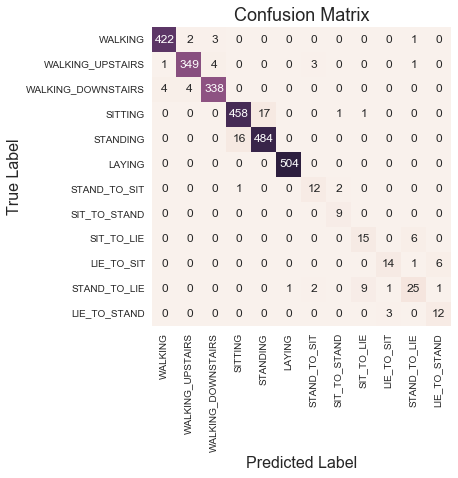

In [76]:
confusion = confusion_matrix(y_test, predicted, labels=labels)
sns.set()
sns.heatmap(confusion.T, square=True,annot=True,fmt='d',cbar=False,xticklabels=labels,yticklabels=labels)
plt.ylabel('True Label', fontsize=16)
plt.xlabel('Predicted Label', fontsize=16)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [77]:
print(classification_report(predicted, y_test,labels=['LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'STAND_TO_LIE', 'STAND_TO_SIT']))

              precision    recall  f1-score   support

  LIE_TO_SIT       0.78      0.67      0.72        21
LIE_TO_STAND       0.63      0.80      0.71        15
  SIT_TO_LIE       0.60      0.71      0.65        21
SIT_TO_STAND       0.75      1.00      0.86         9
STAND_TO_LIE       0.74      0.64      0.68        39
STAND_TO_SIT       0.71      0.80      0.75        15

 avg / total       0.70      0.72      0.71       120



In [78]:
# Save f1-scores to later use for plotting
rf_f1_whole_data = f1_score(predicted, y_test, average=None)

### Bar plots showing f1-scores of each class obtained from KNN and RF classification reports.

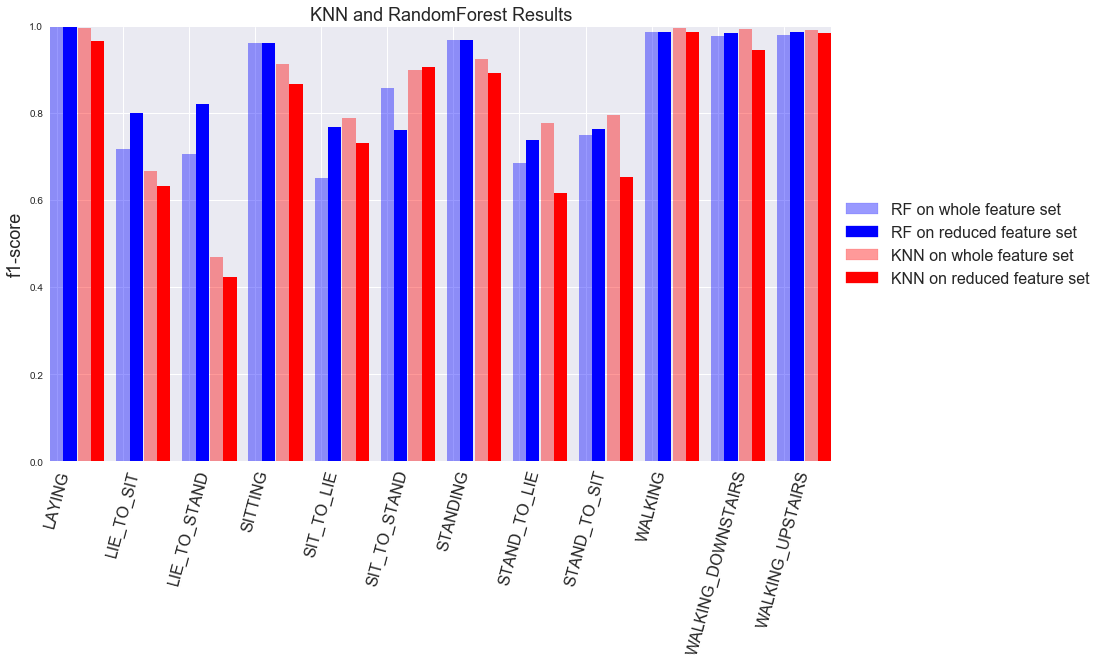

In [79]:
## KNN and RF results on the same plot 
import matplotlib.patches as mpatches
n_groups = 12
labels2 = ['LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SITTING',
          'SIT_TO_LIE', 'SIT_TO_STAND', 'STANDING', 'STAND_TO_LIE', 
          'STAND_TO_SIT', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

fig, ax = plt.subplots(figsize=(14,8))

index = np.arange(n_groups)
bar_width = 0.2

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, rf_f1_whole_data, bar_width,
                 alpha=opacity,
                 color='b',
                 label=labels2)

rects2 = plt.bar(index + bar_width, rf_f1_reduced_data, bar_width,
                 alpha=1,
                 color='b',
                 label=labels2)

rects3 = plt.bar(index + 2.1*bar_width, knn_f1_whole_data, bar_width,
                 alpha=opacity,
                 color='r',
                 label=labels2)

rects4 = plt.bar(index + 3.1*bar_width, knn_f1_reduced_data, bar_width,
                 alpha=1,
                 color='r',
                 label=labels2)

# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, loc=9, bbox_to_anchor=(0.5, -0.1))

ax.set_ylabel("f1-score", fontsize =18)
# ax.set_xlabel("Classes", fontsize =16)
# ax.get_yticklabels().set_fontsize(16)
ax.set_xticks(index)
ax.set_xticklabels(labels2, fontsize = 16)
ax.set_title('KNN and RandomForest Results', fontsize =18)
ax.autoscale(tight=True)
plt.setp(plt.xticks()[1], rotation=75)

RF_whole = mpatches.Patch(color='blue', label='RF on whole feature set',alpha=0.4)
RF_reduced = mpatches.Patch(color='blue', label='RF on reduced feature set',alpha=1)
KNN_whole = mpatches.Patch(color='red', label='KNN on whole feature set',alpha=0.4)
KNN_reduced = mpatches.Patch(color='red', label='KNN on reduced feature set',alpha=1)
plt.legend(handles=[RF_whole, RF_reduced, KNN_whole, KNN_reduced], fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

<h2 align="center">Comparison Tables for f1-scores</h2> 

<h3 align="center">Table 1. f1-score for Postural Transitional Activity Classes</h3> 

|  | KNN | RF         
| :- |:-------------: | :-:
|Original Dataset| 0.74  | 0.71
|Reduced Dataset | 0.65 | 0.77


<h3 align="center">Table 2. f1-score of Complete Classes</h3> 

|  | KNN | RF         
| :- |:-------------: | :-:
|Original Dataset| 0.96  | 0.97
|Reduced Dataset | 0.93 | 0.97
